In [ ]:
import numpy as np


class WeightInitializer:
    @staticmethod
    def initialize_weights(topology, activation_function):

        weights = []
        for x, y in zip(topology[:-1], topology[1:]):
            if activation_function == "relu":
                # He Initialization
                weight_matrix = np.random.randn(y, x) * np.sqrt(2 / x)
            elif activation_function in ["sigmoid", "tanh"]:
                # Xavier Initialization
                weight_matrix = np.random.randn(y, x) * np.sqrt(1 / x)
            else:
                raise ValueError(
                    f"Unsupported activation function: {activation_function}. "
                    "Supported functions: 'relu', 'sigmoid', 'tanh'."
                )
            weights.append(weight_matrix)
        return weights

    @staticmethod
    def initialize_biases(topology):

        return [np.zeros((y, 1)) for y in topology[1:]]

import numpy as np


class ActivationFunction:

    def __init__(self, method: str, beta: float = 1.0):
        self.method = method.lower()
        self.beta = beta
        self.activation, self.activation_prime = self._get_activation_functions()

    def _get_activation_functions(self):
        functions = {
            "sigmoid": (self._sigmoid, self._sigmoid_prime),
            "tanh": (self._tanh, self._tanh_prime),
            "relu": (self._relu, self._relu_prime),
            "softmax": (self._softmax, self._softmax_prime),
        }
        if self.method not in functions:
            raise ValueError(f"Unknown activation function: {self.method}")
        return functions[self.method]

    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-self.beta * z))

    def _sigmoid_prime(self, z: np.ndarray) -> np.ndarray:
        a = self._sigmoid(z)
        return self.beta * a * (1 - a)

    def _tanh(self, z: np.ndarray) -> np.ndarray:
        return np.tanh(self.beta * z)

    def _tanh_prime(self, z: np.ndarray) -> np.ndarray:
        return self.beta * (1 - np.tanh(self.beta * z) ** 2)

    def _relu(self, z: np.ndarray) -> np.ndarray:
        return np.maximum(0, z)

    def _relu_prime(self, z: np.ndarray) -> np.ndarray:
        return np.where(z > 0, 1.0, 0.0)

    def _softmax(self, z: np.ndarray) -> np.ndarray:
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def _softmax_prime(self, z: np.ndarray) -> np.ndarray:
        # La derivada del softmax es más compleja y normalmente se utiliza en combinación con la función de pérdida de entropía cruzada.
        # Para fines prácticos, esta implementación sirve como un placeholder.
        s = self._softmax(z)
        return s * (1 - s)

    def __str__(self) -> str:
        return f"ActivationFunction(method='{self.method}', beta={self.beta})"


import numpy as np


class Optimizer:

    def __init__(
        self,
        method: str = "gradient_descent",
        eta: float = 0.01,
        weight_decay: float = 0.0,  # Add weight decay as a parameter
        **kwargs,
    ):
        self.method = method.lower()
        self.eta = eta
        self.weight_decay = weight_decay  # Store weight decay value

        # Parameters for Momentum
        self.alpha = kwargs.get("alpha", 0.9)

        # Parameters for Adam
        self.beta_1 = kwargs.get("beta_1", 0.9)
        self.beta_2 = kwargs.get("beta_2", 0.999)
        self.epsilon = kwargs.get("epsilon", 1e-8)

        # Initialize moments for Momentum and Adam
        self.v_w, self.v_b = None, None  # Velocities
        self.m_w, self.m_b = None, None  # Moments
        self.t = 0  # Time step for Adam

        # Validate optimization method
        valid_methods = ["gradient_descent", "momentum", "adam"]
        if self.method not in valid_methods:
            raise ValueError(f"Unknown optimization method: {self.method}")

    def update_parameters(self, weights, biases, grads_w, grads_b, mini_batch_size):
        if self.method == "gradient_descent":
            return self._gradient_descent(
                weights, biases, grads_w, grads_b, mini_batch_size
            )
        elif self.method == "momentum":
            return self._momentum(weights, biases, grads_w, grads_b, mini_batch_size)
        elif self.method == "adam":
            return self._adam(weights, biases, grads_w, grads_b, mini_batch_size)

    def _apply_weight_decay(self, weights):
        return [w - self.weight_decay * w for w in weights]

    def _gradient_descent(self, weights, biases, grads_w, grads_b, mini_batch_size):
        lr = self.eta / mini_batch_size

        weights = self._apply_weight_decay(weights)

        new_weights = [w - lr * gw for w, gw in zip(weights, grads_w)]
        new_biases = [b - lr * gb for b, gb in zip(biases, grads_b)]
        return new_weights, new_biases

    def _momentum(self, weights, biases, grads_w, grads_b, mini_batch_size):
        if self.v_w is None:
            # Initialize velocities
            self.v_w = [np.zeros_like(w) for w in weights]
            self.v_b = [np.zeros_like(b) for b in biases]

        lr = self.eta / mini_batch_size
        alpha = self.alpha

        # Apply weight decay to weights
        weights = self._apply_weight_decay(weights)

        # Update velocities
        self.v_w = [alpha * vw - lr * gw for vw, gw in zip(self.v_w, grads_w)]
        self.v_b = [alpha * vb - lr * gb for vb, gb in zip(self.v_b, grads_b)]

        # Update parameters
        new_weights = [w + vw for w, vw in zip(weights, self.v_w)]
        new_biases = [b + vb for b, vb in zip(biases, self.v_b)]
        return new_weights, new_biases

    def _adam(self, weights, biases, grads_w, grads_b, mini_batch_size):
        if self.m_w is None:
            # Initialize first and second moments
            self.m_w = [np.zeros_like(w) for w in weights]
            self.v_w = [np.zeros_like(w) for w in weights]
            self.m_b = [np.zeros_like(b) for b in biases]
            self.v_b = [np.zeros_like(b) for b in biases]

        self.t += 1
        lr_t = self.eta / mini_batch_size
        beta_1, beta_2, epsilon = self.beta_1, self.beta_2, self.epsilon

        # Apply weight decay to weights
        weights = self._apply_weight_decay(weights)

        # Update moments for weights
        self.m_w = [
            beta_1 * mw + (1 - beta_1) * gw for mw, gw in zip(self.m_w, grads_w)
        ]
        self.v_w = [
            beta_2 * vw + (1 - beta_2) * (gw**2) for vw, gw in zip(self.v_w, grads_w)
        ]
        m_w_hat = [mw / (1 - beta_1**self.t) for mw in self.m_w]
        v_w_hat = [vw / (1 - beta_2**self.t) for vw in self.v_w]

        # Update moments for biases
        self.m_b = [
            beta_1 * mb + (1 - beta_1) * gb for mb, gb in zip(self.m_b, grads_b)
        ]
        self.v_b = [
            beta_2 * vb + (1 - beta_2) * (gb**2) for vb, gb in zip(self.v_b, grads_b)
        ]
        m_b_hat = [mb / (1 - beta_1**self.t) for mb in self.m_b]
        v_b_hat = [vb / (1 - beta_2**self.t) for vb in self.v_b]

        # Update parameters
        new_weights = [
            w - lr_t * mwh / (np.sqrt(vwh) + epsilon)
            for w, mwh, vwh in zip(weights, m_w_hat, v_w_hat)
        ]
        new_biases = [
            b - lr_t * mbh / (np.sqrt(vbh) + epsilon)
            for b, mbh, vbh in zip(biases, m_b_hat, v_b_hat)
        ]
        return new_weights, new_biases

    def __str__(self) -> str:
        return f"Optimizer(method='{self.method}', eta={self.eta})"

import numpy as np


class MultilayerPerceptron(object):
    def __init__(
        self,
        seed,
        topology,
        activation_function: ActivationFunction,
        optimizer: Optimizer,
        weights=None,
        biases=None,
    ):
        if seed is not None:
            np.random.seed(seed)

        self.num_layers = len(topology)
        self.sigma = activation_function
        self.optimizer = optimizer
        self.topology = topology

        if weights is not None and biases is not None:
            self.weights = weights
            self.biases = biases
        else:
            self.weights = WeightInitializer.initialize_weights(
                topology, activation_function.method
            )
            self.biases = WeightInitializer.initialize_biases(topology)

    # Returns the output of the neural network when 'a' is giving as input
    def feedforward(self, a, return_activations=False):
        activations = [a]
        for b, w in zip(self.biases, self.weights):
            a = self.sigma.activation(np.dot(w, a) + b)
            activations.append(a)
        if return_activations:
            return activations
        else:
            return a

    # Trains the neural network with mini batches of the training data for the an amount of epochs
    # def fit(self, training_data, epochs, mini_batch_size):
    #     n = len(training_data)

    #     for j in range(epochs):
    #         np.random.shuffle(training_data)
    #         mini_batches = [
    #             training_data[k : k + mini_batch_size]
    #             for k in range(0, n, mini_batch_size)
    #         ]
    #         for mini_batch in mini_batches:
    #             self.update_weights_and_biases(mini_batch, mini_batch_size)

    #         print(f"Epoch {j} complete")

    def fit(self, training_data, epochs, mini_batch_size, patience=10, min_delta=1e-4):
        n = len(training_data)
        pixel_error_history = []

        # Early stopping variables
        best_error = float("inf")  # Best observed error
        wait = 0  # Epochs without improvement

        for epoch in range(epochs):
            # Shuffle training data each epoch
            shuffled_data = training_data[:]
            np.random.shuffle(shuffled_data)
            mini_batches = [
                training_data[k : k + mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]

            # Update weights and biases for each mini-batch
            for mini_batch in mini_batches:
                self.update_weights_and_biases(mini_batch, mini_batch_size)

            # Calculate pixel error at the end of the epoch
            pixel_error = 0
            for x, y in training_data:
                output = self.feedforward(x)
                # Count incorrect pixels (comparing binarized output to target)
                pixel_error += np.sum((output > 0.5).astype(int) != y.astype(int))
            pixel_error_history.append(pixel_error)

            print(f"Epoch {epoch + 1}/{epochs}, Pixel error: {pixel_error}")

            # Early stopping logic
            if pixel_error < best_error - min_delta:
                best_error = pixel_error
                wait = 0  # Reset wait counter
            else:
                wait += 1
                if wait >= patience:
                    print(
                        f"Stopping early at epoch {epoch + 1}. Best pixel error: {best_error}"
                    )
                    break

        return pixel_error_history

    # Uses the mini batch to calculate the adjustments to the weights and biases
    def update_weights_and_biases(self, mini_batch, mini_batch_size):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backpropagation(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        self.weights, self.biases = self.optimizer.update_parameters(
            self.weights, self.biases, nabla_w, nabla_b, mini_batch_size
        )

    # Returns the gradients
    def backpropagation(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # Feedforward
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            # Calculate and store preactivations
            z = np.dot(w, activation) + b
            zs.append(z)
            # Calculate and store activations
            activation = self.sigma.activation(z)
            activations.append(activation)

        # Backward pass
        # Special treatment for output layer
        delta = self.cost_derivative(activations[-1], y) * self.sigma.activation_prime(
            zs[-1]
        )
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].T)

        for l in range(2, self.num_layers):
            delta = np.dot(self.weights[-l + 1].T, delta) * self.sigma.activation_prime(
                zs[-l]
            )
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].T)

        return (nabla_b, nabla_w)

    # Evaluates the accuracy metric for the neural network
    def evaluate(self, test_data, epsilon):
        test_results = [
            (np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in test_data
        ]
        return sum(int(abs(x - y) < epsilon) for (x, y) in test_results) / len(
            test_data
        )

    # Derivative of the error function (Squared Error) with respect to the activatio
    def cost_derivative(self, output_activations, y):
        return output_activations - y

    def encode(self, x):
        activation = x
        for b, w in zip(
            self.biases[: self.num_layers // 2], self.weights[: self.num_layers // 2]
        ):
            activation = self.sigma.activation(np.dot(w, activation) + b)
        return activation

    def decode(self, z):
        activation = z
        for b, w in zip(
            self.biases[self.num_layers // 2 :], self.weights[self.num_layers // 2 :]
        ):
            activation = self.sigma.activation(np.dot(w, activation) + b)
        return activation

    ##################################### Save model or load model #########################################################

    def save_model(self, filename):
        weights_array = np.array(self.weights, dtype=object)
        biases_array = np.array(self.biases, dtype=object)
        topology_array = np.array(self.topology, dtype=object)

        np.savez_compressed(
            filename,
            weights=weights_array,
            biases=biases_array,
            topology=topology_array,
        )

    @classmethod
    def load_model(cls, filename, activation_function, optimizer, seed=None):
        data = np.load(filename, allow_pickle=True)
        weights = data["weights"]
        biases = data["biases"]
        topology = data["topology"].tolist()

        weights = weights.tolist()
        biases = biases.tolist()

        model = cls(
            seed=seed,
            topology=topology,
            activation_function=activation_function,
            optimizer=optimizer,
            weights=weights,
            biases=biases,
        )
        return model


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

def print_letter(char):
    # Retrieve the data for the character
    image_data = data[char]
    # Reshape the data into the original image dimensions (7 rows x 5 columns)
    image = image_data.reshape(7, 5)
    # Display the image
    plt.imshow(image, cmap='gray_r')  # Use 'gray_r' for better contrast
    plt.title(f'Letter: {char}')
    plt.axis('off')
    plt.show()

    # Normalize data for activation functions
def normalize_data(data, activation_method):
    if activation_method == 'sigmoid':
        # Normalize to [0, 1] for sigmoid
        return {k: v / 1.0 for k, v in data.items()}
    elif activation_method == 'tanh':
        # Normalize to [-1, 1] for tanh
        return {k: 2 * v - 1 for k, v in data.items()}
    else:
        # No normalization needed for relu
        return data


def load_data():
    font_data = [
        [0x04, 0x04, 0x02, 0x00, 0x00, 0x00, 0x00],   # 0x60, `
        [0x00, 0x0e, 0x01, 0x0d, 0x13, 0x13, 0x0d],   # 0x61, a
        [0x10, 0x10, 0x10, 0x1c, 0x12, 0x12, 0x1c],   # 0x62, b
        [0x00, 0x00, 0x00, 0x0e, 0x10, 0x10, 0x0e],   # 0x63, c
        [0x01, 0x01, 0x01, 0x07, 0x09, 0x09, 0x07],   # 0x64, d
        [0x00, 0x00, 0x0e, 0x11, 0x1f, 0x10, 0x0f],   # 0x65, e
        [0x06, 0x09, 0x08, 0x1c, 0x08, 0x08, 0x08],   # 0x66, f
        [0x0e, 0x11, 0x13, 0x0d, 0x01, 0x01, 0x0e],   # 0x67, g
        [0x10, 0x10, 0x10, 0x16, 0x19, 0x11, 0x11],   # 0x68, h
        [0x00, 0x04, 0x00, 0x0c, 0x04, 0x04, 0x0e],   # 0x69, i
        [0x02, 0x00, 0x06, 0x02, 0x02, 0x12, 0x0c],   # 0x6a, j
        [0x10, 0x10, 0x12, 0x14, 0x18, 0x14, 0x12],   # 0x6b, k
        [0x0c, 0x04, 0x04, 0x04, 0x04, 0x04, 0x04],   # 0x6c, l
        [0x00, 0x00, 0x0a, 0x15, 0x15, 0x11, 0x11],   # 0x6d, m
        [0x00, 0x00, 0x16, 0x19, 0x11, 0x11, 0x11],   # 0x6e, n
        [0x00, 0x00, 0x0e, 0x11, 0x11, 0x11, 0x0e],   # 0x6f, o
        [0x00, 0x1c, 0x12, 0x12, 0x1c, 0x10, 0x10],   # 0x70, p
        [0x00, 0x07, 0x09, 0x09, 0x07, 0x01, 0x01],   # 0x71, q
        [0x00, 0x00, 0x16, 0x19, 0x10, 0x10, 0x10],   # 0x72, r
        [0x00, 0x00, 0x0f, 0x10, 0x0e, 0x01, 0x1e],   # 0x73, s
        [0x08, 0x08, 0x1c, 0x08, 0x08, 0x09, 0x06],   # 0x74, t
        [0x00, 0x00, 0x11, 0x11, 0x11, 0x13, 0x0d],   # 0x75, u
        [0x00, 0x00, 0x11, 0x11, 0x11, 0x0a, 0x04],   # 0x76, v
        [0x00, 0x00, 0x11, 0x11, 0x15, 0x15, 0x0a],   # 0x77, w
        [0x00, 0x00, 0x11, 0x0a, 0x04, 0x0a, 0x11],   # 0x78, x
        [0x00, 0x11, 0x11, 0x0f, 0x01, 0x11, 0x0e],   # 0x79, y
        [0x00, 0x00, 0x1f, 0x02, 0x04, 0x08, 0x1f],   # 0x7a, z
        [0x06, 0x08, 0x08, 0x10, 0x08, 0x08, 0x06],   # 0x7b, {
        [0x04, 0x04, 0x04, 0x00, 0x04, 0x04, 0x04],   # 0x7c, |
        [0x0c, 0x02, 0x02, 0x01, 0x02, 0x02, 0x0c],   # 0x7d, }
        [0x08, 0x15, 0x02, 0x00, 0x00, 0x00, 0x00],   # 0x7e, ~
        [0x1f, 0x1f, 0x1f, 0x1f, 0x1f, 0x1f, 0x1f]    # 0x7f, DEL
    ]
    images = []
    for char in font_data:
        image = []
        for row in char:
            bits = [(row >> i) & 1 for i in range(4, -1, -1)]  # 5 bits per row
            image.extend(bits)
        images.append(image)
    data_array = np.array(images, dtype=np.float32)

    # Create a list of characters from ASCII codes 0x60 to 0x7e
    char_list = [chr(i) for i in range(0x60, 0x7f)]  # Up to 0x7e
    char_list.append('DEL')  # Append 'DEL' for the last character

    # Map each character to its corresponding data
    data_dict = {c: data_array[i] for i, c in enumerate(char_list)}
    return data_dict

# Load the data and prepare the training set
data = load_data()
training_data = [(x.reshape(-1, 1), x.reshape(-1, 1)) for x in data.values()]

In [ ]:



# Definir las diferentes configuraciones a probar
optimizers = ['gradient_descent', 'momentum', 'adam']
learning_rates = [0.01, 0.001]
activation_functions = ['sigmoid', 'tanh', 'relu']
batch_sizes = [6, 12]

# Generar todas las combinaciones posibles de configuraciones
configs = list(product(optimizers, learning_rates, activation_functions, batch_sizes))


# Para reducir el tiempo de entrenamiento, seleccionamos un subconjunto de configuraciones
# configs = [
#     ('adam', 0.001, 'tanh', 6),
#     ('gradient_descent', 0.01, 'sigmoid', 6),
#     ('momentum', 0.01, 'tanh', 6),
#     ('adam', 0.001, 'relu', 6),
#     ('gradient_descent', 0.001, 'tanh', 12),
#     ('momentum', 0.001, 'relu', 12),
#     ('adam', 0.01, 'sigmoid', 12)
# ]

# Inicializar una lista para almacenar las historias de error y las etiquetas
histories = []

# Definir el número de épocas para el entrenamiento
epochs = 100000  # Puedes ajustar este valor según tus recursos computacionales

# Entrenar los modelos con las diferentes configuraciones
for optimizer_method, eta, activation_method, batch_size in configs:
    print(f"Entrenando modelo con {optimizer_method}, eta={eta}, {activation_method}, batch_size={batch_size}")

    # Crear la función de activación
    activation_function = ActivationFunction(method=activation_method)
    # Crear el optimizador
    optimizer = Optimizer(method=optimizer_method, eta=eta)
    # Definir la topología de la red
    topology = [35, 100, 20, 50, 10,2, 10, 50, 20, 100, 35]
    # Crear el MLP
    mlp = MultilayerPerceptron(
        seed=42,
        topology=topology,
        activation_function=activation_function,
        optimizer=optimizer
    )
    # Entrenar el modelo
    pixel_error_history = mlp.fit(training_data, epochs=epochs, mini_batch_size=batch_size, patience=1000, min_delta=1e-3)
    # Almacenar la historia y la etiqueta
    label = f'{optimizer_method}, eta={eta}, {activation_method}, batch={batch_size}'
    histories.append((label, pixel_error_history))




Streaming output truncated to the last 5000 lines.
Epoch 884/100000, Pixel error: 199
Epoch 885/100000, Pixel error: 197
Epoch 886/100000, Pixel error: 198
Epoch 887/100000, Pixel error: 198
Epoch 888/100000, Pixel error: 198
Epoch 889/100000, Pixel error: 199
Epoch 890/100000, Pixel error: 199
Epoch 891/100000, Pixel error: 199
Epoch 892/100000, Pixel error: 199
Epoch 893/100000, Pixel error: 199
Epoch 894/100000, Pixel error: 197
Epoch 895/100000, Pixel error: 198
Epoch 896/100000, Pixel error: 199
Epoch 897/100000, Pixel error: 200
Epoch 898/100000, Pixel error: 199
Epoch 899/100000, Pixel error: 198
Epoch 900/100000, Pixel error: 196
Epoch 901/100000, Pixel error: 197
Epoch 902/100000, Pixel error: 196
Epoch 903/100000, Pixel error: 196
Epoch 904/100000, Pixel error: 198
Epoch 905/100000, Pixel error: 198
Epoch 906/100000, Pixel error: 196
Epoch 907/100000, Pixel error: 197
Epoch 908/100000, Pixel error: 197
Epoch 909/100000, Pixel error: 197
Epoch 910/100000, Pixel error: 196
Epoc

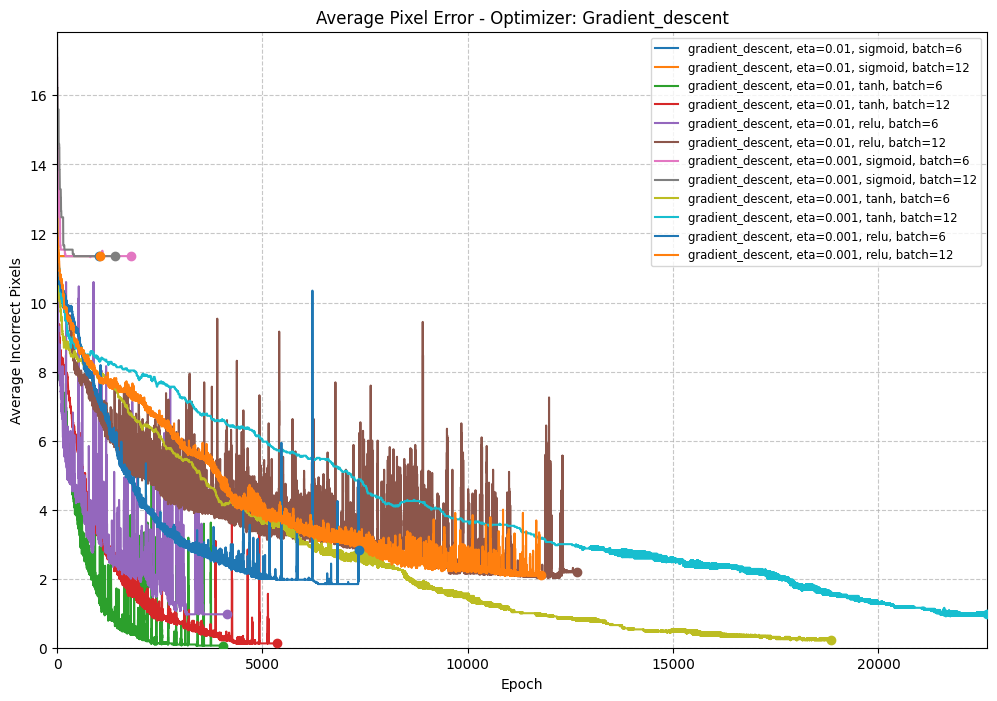

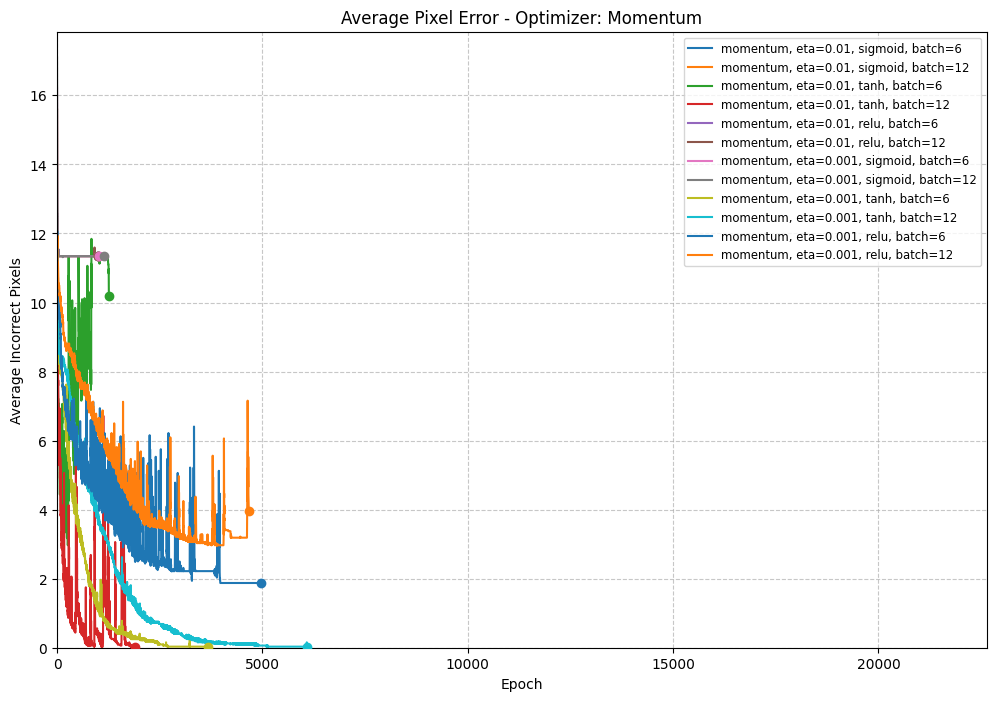

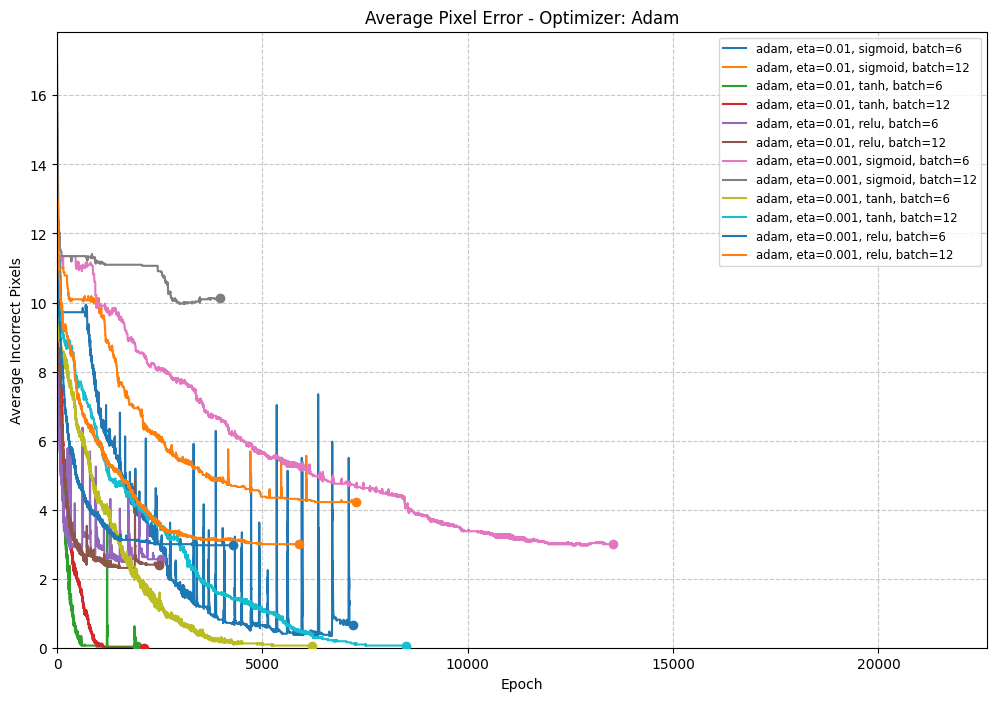

In [ ]:
# Group histories by optimizer
optimizer_histories = {
    'gradient_descent': [],
    'momentum': [],
    'adam': []
}

# Sort histories into groups based on the optimizer in the label
for label, history in histories:
    for optimizer in optimizer_histories.keys():
        if optimizer in label:
            optimizer_histories[optimizer].append((label, history))
            break

# Calculate global x and y limits
total_examples = len(training_data)

# Find the maximum number of epochs and the max/min average error
max_epochs = 0
max_error = 0
for _, history in histories:
    max_epochs = max(max_epochs, len(history))
    max_error = max(max_error, max(error / total_examples for error in history))

# Plot each optimizer's results in separate graphs with the same scale
for optimizer, opt_histories in optimizer_histories.items():
    plt.figure(figsize=(12, 8))
    for label, history in opt_histories:
        # Convert the history to average error
        average_error_history = [error / total_examples for error in history]
        # Extract the number of epochs trained
        epochs_trained = len(average_error_history)
        # Create the range of epochs
        x_values = range(epochs_trained)
        # Plot the average error history
        plt.plot(x_values, average_error_history, label=label)
        # Add an indicator for the stopping point
        plt.scatter(
            [epochs_trained - 1],  # Last epoch trained
            [average_error_history[-1]],  # Final average error
            zorder=5
        )
    # Set consistent scales
    plt.xlim(0, max_epochs)
    plt.ylim(0, max_error)
    plt.xlabel('Epoch')
    plt.ylabel('Average Incorrect Pixels')
    plt.title(f'Average Pixel Error - Optimizer: {optimizer.capitalize()}')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


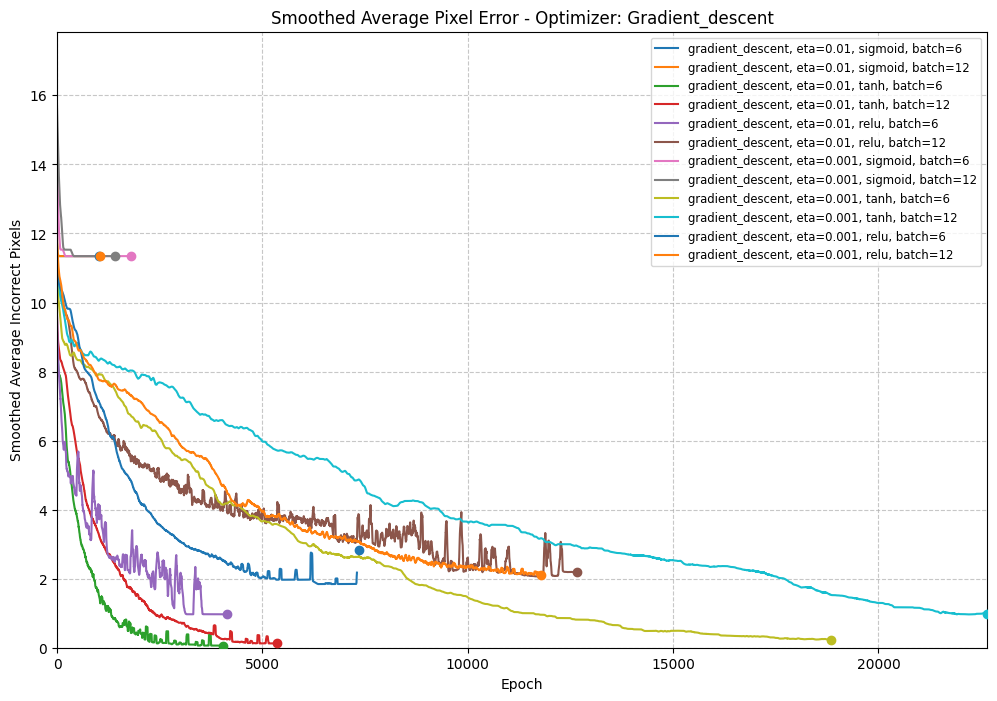

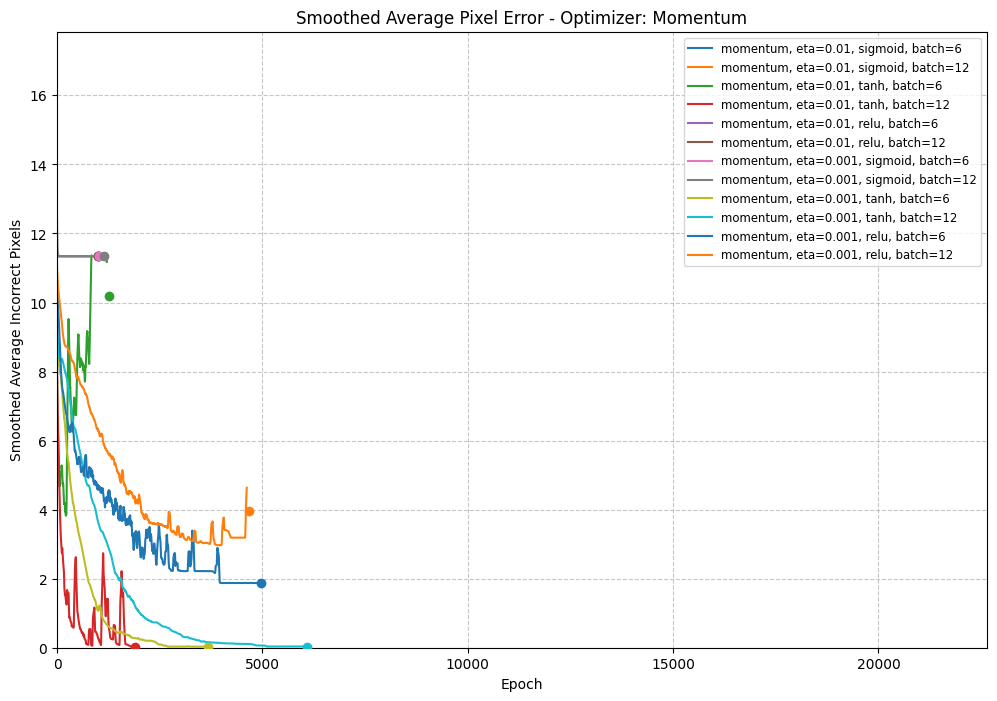

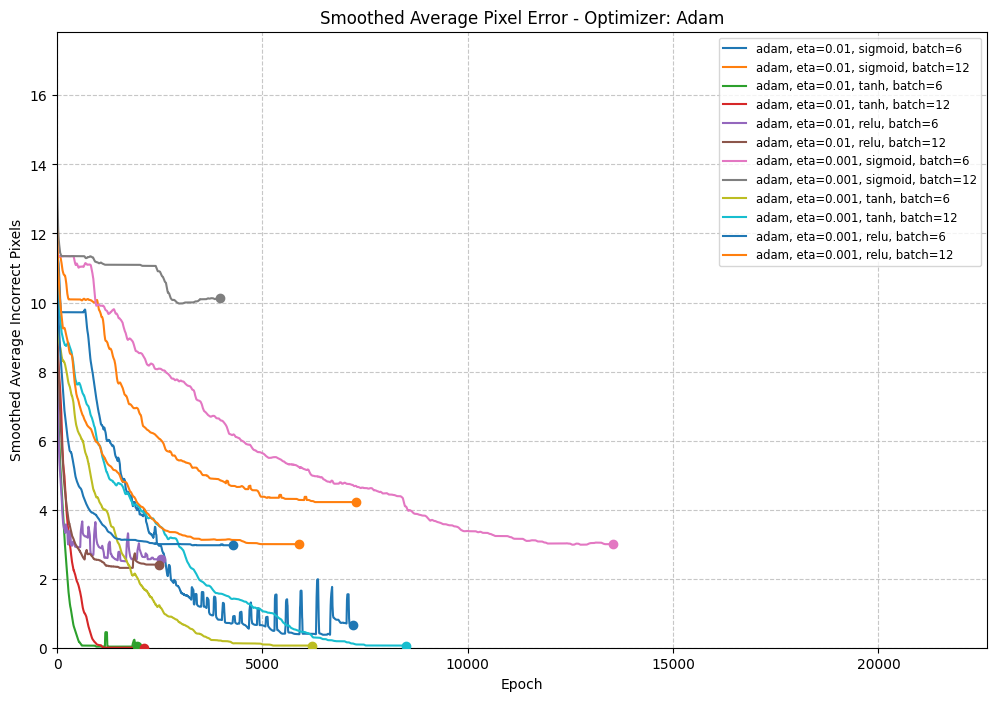

In [ ]:
import numpy as np

# Function to apply a moving average filter to smooth the line
def smooth_data(data, window_size=50):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Group histories by optimizer
optimizer_histories = {
    'gradient_descent': [],
    'momentum': [],
    'adam': []
}

# Sort histories into groups based on the optimizer in the label
for label, history in histories:
    for optimizer in optimizer_histories.keys():
        if optimizer in label:
            optimizer_histories[optimizer].append((label, history))
            break

# Calculate global x and y limits
total_examples = len(training_data)

# Find the maximum number of epochs and the max/min average error
max_epochs = 0
max_error = 0
for _, history in histories:
    max_epochs = max(max_epochs, len(history))
    max_error = max(max_error, max(error / total_examples for error in history))

# Plot each optimizer's results in separate graphs with smoothed lines
for optimizer, opt_histories in optimizer_histories.items():
    plt.figure(figsize=(12, 8))
    for label, history in opt_histories:
        # Convert the history to average error
        average_error_history = [error / total_examples for error in history]
        # Smooth the average error history
        smoothed_error_history = smooth_data(average_error_history, window_size=50)
        # Extract the number of epochs trained
        epochs_trained = len(average_error_history)
        smoothed_epochs = range(len(smoothed_error_history))
        # Plot the smoothed average error history
        plt.plot(smoothed_epochs, smoothed_error_history, label=label)
        # Add an indicator for the stopping point
        plt.scatter(
            [epochs_trained - 1],  # Last epoch trained
            [average_error_history[-1]],  # Final average error
            zorder=5
        )
    # Set consistent scales
    plt.xlim(0, max_epochs)
    plt.ylim(0, max_error)
    plt.xlabel('Epoch')
    plt.ylabel('Smoothed Average Incorrect Pixels')
    plt.title(f'Smoothed Average Pixel Error - Optimizer: {optimizer.capitalize()}')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


Streaming output truncated to the last 5000 lines.
Epoch 323/10000, Pixel error: 45
Epoch 324/10000, Pixel error: 45
Epoch 325/10000, Pixel error: 45
Epoch 326/10000, Pixel error: 43
Epoch 327/10000, Pixel error: 47
Epoch 328/10000, Pixel error: 42
Epoch 329/10000, Pixel error: 42
Epoch 330/10000, Pixel error: 42
Epoch 331/10000, Pixel error: 41
Epoch 332/10000, Pixel error: 42
Epoch 333/10000, Pixel error: 39
Epoch 334/10000, Pixel error: 42
Epoch 335/10000, Pixel error: 41
Epoch 336/10000, Pixel error: 42
Epoch 337/10000, Pixel error: 42
Epoch 338/10000, Pixel error: 40
Epoch 339/10000, Pixel error: 40
Epoch 340/10000, Pixel error: 44
Epoch 341/10000, Pixel error: 35
Epoch 342/10000, Pixel error: 50
Epoch 343/10000, Pixel error: 35
Epoch 344/10000, Pixel error: 45
Epoch 345/10000, Pixel error: 38
Epoch 346/10000, Pixel error: 38
Epoch 347/10000, Pixel error: 40
Epoch 348/10000, Pixel error: 37
Epoch 349/10000, Pixel error: 40
Epoch 350/10000, Pixel error: 35
Epoch 351/10000, Pixel er

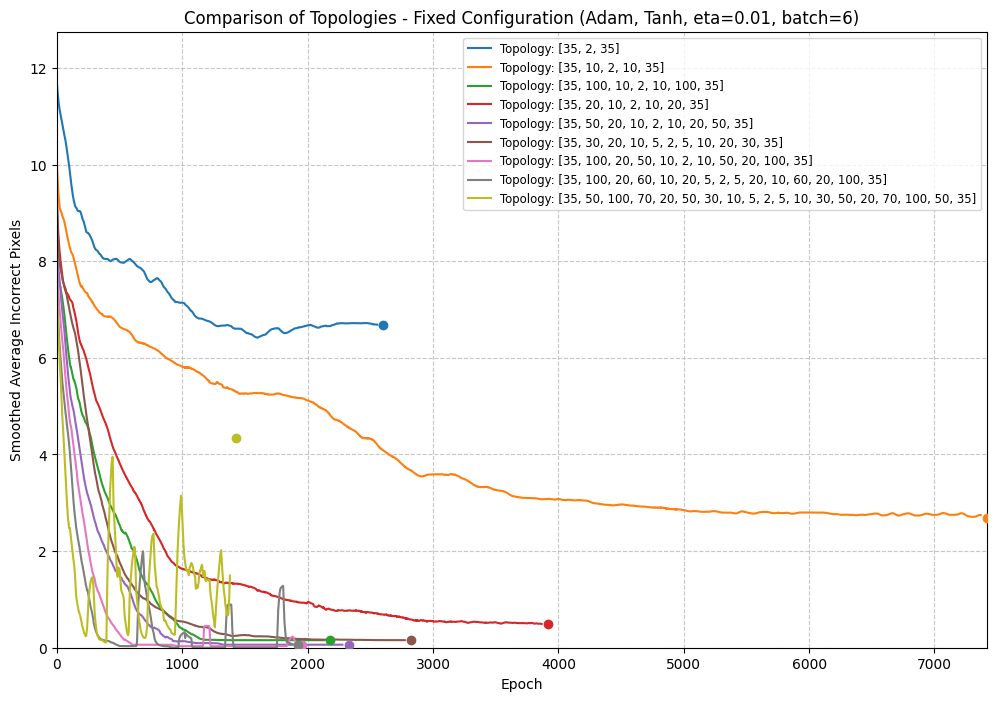

In [ ]:
# Define the fixed configuration
optimizer_method = 'adam'
activation_method = 'tanh'
eta = 0.01
batch_size = 6

# Define the topologies to compare
topologies = [
        [35, 2, 35],
        [35, 10, 2, 10, 35],
        [35, 100, 10, 2, 10, 100, 35],
        [35, 20, 10, 2, 10, 20, 35],
        [35, 50 ,20, 10, 2, 10,20 ,50,  35],
        [35, 30, 20, 10, 5, 2, 5, 10, 20, 30, 35],
        [35, 100, 20, 50, 10,2, 10, 50, 20, 100, 35],
        [35, 100, 20, 60, 10, 20, 5, 2 ,5, 20, 10, 60, 20,100, 35],
        [35, 50, 100, 70, 20, 50, 30, 10, 5,2, 5, 10,30, 50, 20, 70, 100, 50, 35],

]

# Initialize a list to store the histories and labels
histories = []

# Train the model for each topology
for topology in topologies:
    print(f"Training model with topology: {topology}")

    # Create the activation function
    activation_function = ActivationFunction(method=activation_method)

    # Create the optimizer
    optimizer = Optimizer(method=optimizer_method, eta=eta)

    # Create the MLP
    mlp = MultilayerPerceptron(
        seed=42,
        topology=topology,
        activation_function=activation_function,
        optimizer=optimizer
    )

    # Train the model
    pixel_error_history = mlp.fit(
        training_data,
        epochs=10000,  # Adjust epochs as needed
        mini_batch_size=batch_size,
        patience=1000,  # Early stopping patience
        min_delta=1e-3  # Minimum improvement
    )

    # Store the history and topology as a label
    label = f'Topology: {topology}'
    histories.append((label, pixel_error_history))

# Plot the results for each topology
def smooth_data(data, window_size=50):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(12, 8))
total_examples = len(training_data)

for label, history in histories:
    # Convert the history to average error
    average_error_history = [error / total_examples for error in history]
    # Smooth the average error history
    smoothed_error_history = smooth_data(average_error_history, window_size=50)
    # Extract the number of epochs trained
    epochs_trained = len(average_error_history)
    smoothed_epochs = range(len(smoothed_error_history))
    # Plot the smoothed average error history
    plt.plot(smoothed_epochs, smoothed_error_history, label=label)
    # Add an indicator for the stopping point
    plt.scatter(
        [epochs_trained - 1],  # Last epoch trained
        [average_error_history[-1]],  # Final average error
        zorder=5
    )

# Set consistent scales
max_epochs = max(len(history) for _, history in histories)
max_error = max(max(error / total_examples for error in history) for _, history in histories)
plt.xlim(0, max_epochs)
plt.ylim(0, max_error)
plt.xlabel('Epoch')
plt.ylabel('Smoothed Average Incorrect Pixels')
plt.title('Comparison of Topologies - Fixed Configuration (Adam, Tanh, eta=0.01, batch=6)')
plt.legend(loc='best', fontsize='small')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Function to add multiple noisy versions of each training sample
def add_noise_variable(data, min_level, max_level, augmentations=5):
    noisy_data = []
    for x, y in data:
        for _ in range(augmentations):
            noise_level = np.random.uniform(min_level, max_level)
            noise = np.random.binomial(1, noise_level, x.shape)
            noisy_x = np.where(noise == 1, 1 - x, x)
            noisy_data.append((noisy_x, y))
    return noisy_data

# Train the denoising autoencoder with multiple noisy versions
print("\nCreating training dataset with multiple noisy samples (5 augmentations per input)")
noisy_training_data = add_noise_variable(training_data, min_level=0.2, max_level=0.2, augmentations=10)

topology = [35, 100, 20, 50, 10, 2, 10, 50, 20, 100, 35]

# Function to evaluate the model
def evaluate_model_on_letters(model, data, noise_level):
    pixel_accuracies = []
    for original_x, _ in data:
        # Add noise to the input
        noise = np.random.binomial(1, noise_level, original_x.shape)
        noisy_x = np.where(noise == 1, 1 - original_x, original_x)

        # Reconstruct the input
        reconstructed_x = model.feedforward(noisy_x)
        reconstructed_x_binary = (reconstructed_x > 0.5).astype(int)

        # Calculate pixel accuracy
        accuracy = np.mean((original_x == reconstructed_x_binary).astype(float)) * 100
        pixel_accuracies.append(accuracy)

    print(f"Average Pixel Accuracy at noise level {noise_level}: {np.mean(pixel_accuracies):.2f}%")
    return pixel_accuracies


optimizer = Optimizer(method='adam', eta=0.01, weight_decay=0)

mlp_denoising = MultilayerPerceptron(
    seed=42,
    topology=topology,
    activation_function=ActivationFunction(method='tanh'),
    optimizer=optimizer
)

pixel_error_history = mlp_denoising.fit(
    training_data=noisy_training_data,
    epochs=1000,
    mini_batch_size=6,
    patience=1000,
    min_delta=1e-5
)

# Evaluate denoising at different noise levels
noise_levels = [0.1, 0.3, 0.5]
for noise_level in noise_levels:
    evaluate_model_on_letters(mlp_denoising, training_data, noise_level=noise_level)


In [ ]:
# Function to evaluate the model (unchanged)
def evaluate_model_on_letters(model, data, noise_level):
    pixel_accuracies = []
    for original_x, _ in data:
        # Add noise to the input
        noise = np.random.binomial(1, noise_level, original_x.shape)
        noisy_x = np.where(noise == 1, 1 - original_x, original_x)

        # Reconstruct the input
        reconstructed_x = model.feedforward(noisy_x)
        reconstructed_x_binary = (reconstructed_x > 0.5).astype(int)

        # Calculate pixel accuracy
        accuracy = np.mean((original_x == reconstructed_x_binary).astype(float)) * 100
        pixel_accuracies.append(accuracy)

    avg_accuracy = np.mean(pixel_accuracies)  # Average accuracy
    print(f"Average Pixel Accuracy at noise level {noise_level}: {avg_accuracy:.2f}%")
    return avg_accuracy  # Return the average accuracy

# Topologies to test (unchanged)
topologies = [
    [35, 100, 20, 50, 10, 2, 10, 50, 20, 100, 35],
    [35, 100, 20, 50, 10, 3, 10, 50, 20, 100, 35],
    [35, 100, 20, 50, 10, 4, 10, 50, 20, 100, 35]
]

results = {}

# Train and evaluate each topology
for topology in topologies:
    noisy_training_data = add_noise_variable(training_data, min_level=0.2, max_level=0.2, augmentations=10)
    optimizer = Optimizer(method='adam', eta=0.01, weight_decay=0)
    mlp_denoising = MultilayerPerceptron(
        seed=42,
        topology=topology,
        activation_function=ActivationFunction(method='tanh'),
        optimizer=optimizer
    )
    mlp_denoising.fit(training_data=noisy_training_data, epochs=1000, mini_batch_size=6, patience=1000, min_delta=1e-5)
    # Store average pixel accuracies for each noise level
    results[str(topology)] = [
        evaluate_model_on_letters(mlp_denoising, training_data, noise_level) for noise_level in [0.1, 0.3, 0.5]
    ]

# Plot results (corrected)
for topology, accuracies in results.items():
    plt.plot([0.1, 0.3, 0.5], accuracies, label=f"Topology: {topology}")

plt.xlabel("Noise Level")
plt.ylabel("Average Pixel Accuracy (%)")
plt.title("Denoising Autoencoder Performance Across Topologies")
plt.legend()
plt.show()


In [ ]:
def test_denoising(model, data, noise_level):
    # Seleccionar una imagen al azar
    idx = np.random.randint(0, len(data))
    original_x, _ = data[idx]
    # Añadir ruido
    noise = np.random.binomial(1, noise_level, original_x.shape)
    noisy_x = np.where(noise == 1, 1 - original_x, original_x)
    # Pasar por el autoencoder
    reconstructed_x = model.feedforward(noisy_x)
    # Binarizar la salida
    reconstructed_x_binary = (reconstructed_x > 0.5).astype(int)
    # Mostrar las imágenes
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(original_x.reshape(7, 5), cmap='gray_r')
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(noisy_x.reshape(7, 5), cmap='gray_r')
    axes[1].set_title(f'Con ruido (Nivel: {noise_level})')
    axes[1].axis('off')

    axes[2].imshow(reconstructed_x_binary.reshape(7, 5), cmap='gray_r')
    axes[2].set_title('Reconstruido')
    axes[2].axis('off')

    plt.show()

# Probar el modelo entrenado con un nivel de ruido específico
test_denoising(mlp_denoising, training_data, noise_level=0.1)
